# Recommendation System

In [2]:
# Core data processing
import numpy as np
import pandas as pd
import re

# Database
from sqlalchemy import create_engine

# Natural Language Processing
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Machine Learning - Core
from catboost import CatBoostClassifier

# Machine Learning - Scikit-learn components
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lefukuro/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/lefukuro/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
"""
DATA LOADING FROM DATABASE

 Purpose: Load and combine user, post, and interaction data from PostgreSQL

  users: User demographic information
  posts_text: Post`s content 
  uniq_act: Reactions of all unique users
  acts: Action batch
"""
engine = create_engine(
    "postgresql://robot-startml-ro:pheiph0hahj1Vaif@"
    "postgres.lab.karpov.courses:6432/startml"
)

users = pd.read_sql("SELECT * FROM public.user_data;", con=engine)
posts_text = pd.read_sql("SELECT * FROM public.post_text_df;", con=engine)
uniq_act = pd.read_sql("SELECT DISTINCT ON (user_id, target, action) user_id, post_id, action, timestamp, target FROM public.feed_data WHERE action='view';", con=engine)
acts = pd.read_sql("SELECT * FROM public.feed_data WHERE action='view' ORDER BY random() LIMIT 3000000;", con=engine)

# Combine interaction data: unique actions + sampled interactions
all_actions = pd.concat([uniq_act, acts], axis=0)
df = pd.merge(users, all_actions, on='user_id',how='left')

## EDA

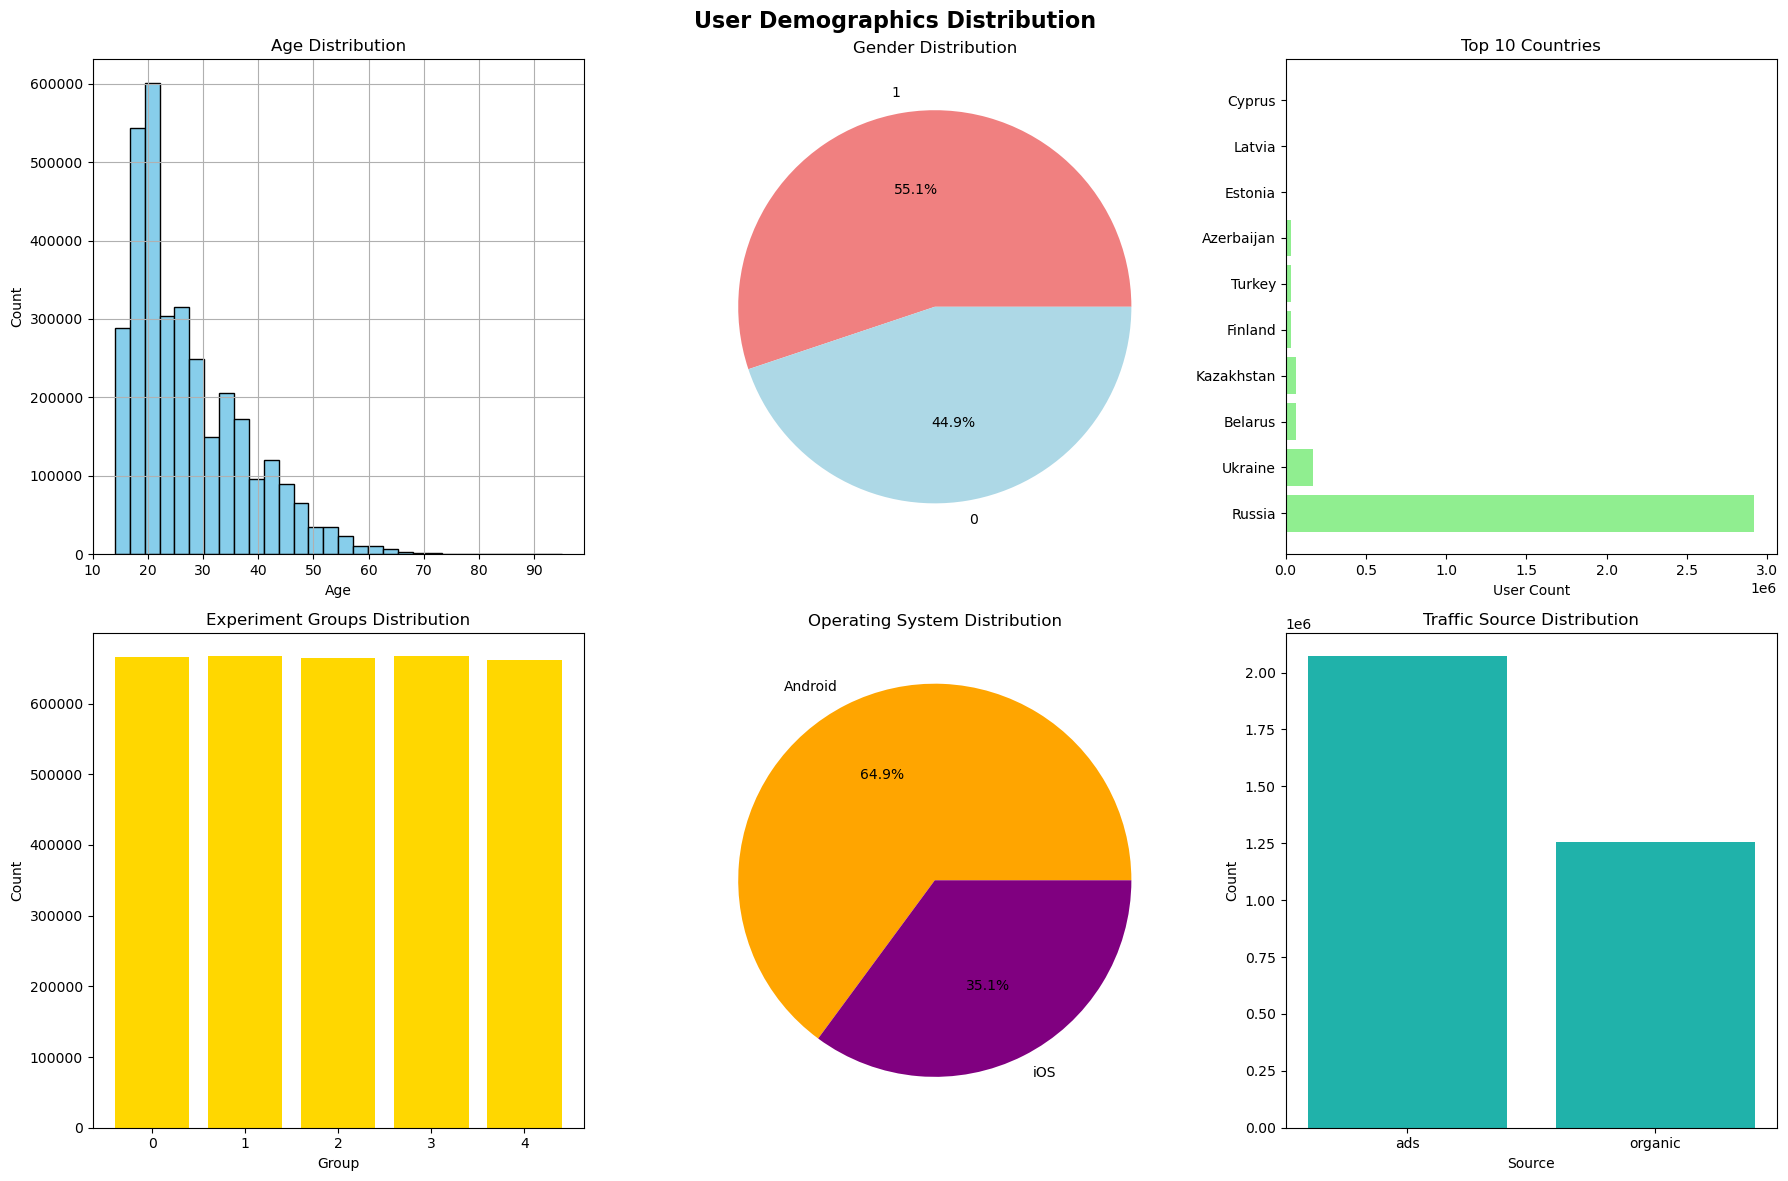

Age statistics:
Mean: 27.2, Median: 24.0
Min: 14, Max: 95
Gender ratio: {1: 1834352, 0: 1492055}


In [4]:
# User demographics analysis

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('User Demographics Distribution', fontsize=16, fontweight='bold')

# Age distribution
df['age'].hist(bins=30, ax=axes[0,0], color='skyblue', edgecolor='black')
axes[0,0].set_title('Age Distribution')
axes[0,0].set_xlabel('Age')
axes[0,0].set_ylabel('Count')

# Gender distribution
gender_counts = df['gender'].value_counts()
axes[0,1].pie(gender_counts.values, labels=gender_counts.index, autopct='%1.1f%%', colors=['lightcoral', 'lightblue'])
axes[0,1].set_title('Gender Distribution')

# Country distribution
country_top10 = df['country'].value_counts().head(10)
axes[0,2].barh(range(len(country_top10)), country_top10.values, color='lightgreen')
axes[0,2].set_yticks(range(len(country_top10)))
axes[0,2].set_yticklabels(country_top10.index)
axes[0,2].set_title('Top 10 Countries')
axes[0,2].set_xlabel('User Count')

# Experiment groups
exp_counts = df['exp_group'].value_counts()
axes[1,0].bar(exp_counts.index, exp_counts.values, color='gold')
axes[1,0].set_title('Experiment Groups Distribution')
axes[1,0].set_xlabel('Group')
axes[1,0].set_ylabel('Count')

# OS distribution
os_counts = df['os'].value_counts()
axes[1,1].pie(os_counts.values, labels=os_counts.index, autopct='%1.1f%%', colors=['orange', 'purple'])
axes[1,1].set_title('Operating System Distribution')

# Traffic source
source_counts = df['source'].value_counts()
axes[1,2].bar(source_counts.index, source_counts.values, color='lightseagreen')
axes[1,2].set_title('Traffic Source Distribution')
axes[1,2].set_xlabel('Source')
axes[1,2].set_ylabel('Count')

plt.tight_layout()
plt.show()

# Demographic statistics
print(f"Age statistics:")
print(f"Mean: {df['age'].mean():.1f}, Median: {df['age'].median():.1f}")
print(f"Min: {df['age'].min()}, Max: {df['age'].max()}")
print(f"Gender ratio: {gender_counts.to_dict()}")


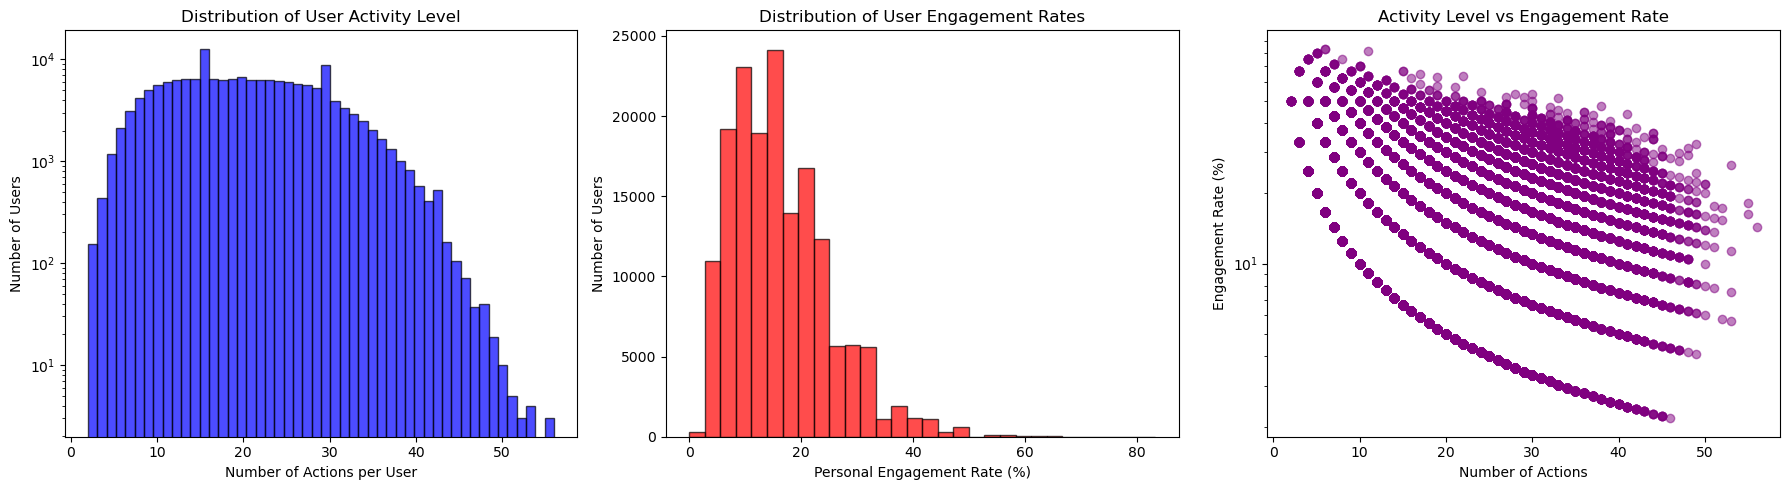

User Behavior Statistics:
Average actions per user: 20.4
Median actions per user: 20.0
Most active user: 56 actions
Average personal engagement rate: 16.59%
Correlation (activity vs engagement): -0.247


In [5]:
# User behavior analysis
fig.suptitle('Content and Engagement Analysis', fontsize=16, fontweight='bold')

# User activity levels
user_activity = df.groupby('user_id').size()
user_engagement = df.groupby('user_id')['target'].mean()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# User activity distribution
axes[0].hist(user_activity, bins=50, color='blue', alpha=0.7, edgecolor='black')
axes[0].set_title('Distribution of User Activity Level')
axes[0].set_xlabel('Number of Actions per User')
axes[0].set_ylabel('Number of Users')
axes[0].set_yscale('log')

# User engagement distribution
axes[1].hist(user_engagement * 100, bins=30, color='red', alpha=0.7, edgecolor='black')
axes[1].set_title('Distribution of User Engagement Rates')
axes[1].set_xlabel('Personal Engagement Rate (%)')
axes[1].set_ylabel('Number of Users')

# Activity vs Engagement scatter
axes[2].scatter(user_activity, user_engagement * 100, alpha=0.5, color='purple')
axes[2].set_title('Activity Level vs Engagement Rate')
axes[2].set_xlabel('Number of Actions')
axes[2].set_ylabel('Engagement Rate (%)')
axes[2].set_yscale('log')

plt.tight_layout()
plt.show()

print("User Behavior Statistics:")
print(f"Average actions per user: {user_activity.mean():.1f}")
print(f"Median actions per user: {user_activity.median():.1f}")
print(f"Most active user: {user_activity.max()} actions")
print(f"Average personal engagement rate: {user_engagement.mean() * 100:.2f}%")
print(f"Correlation (activity vs engagement): {user_activity.corr(user_engagement):.3f}")

In [9]:
# Display information about the DataFrames
print("Data Info:")
df.info()

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3326407 entries, 0 to 3326406
Data columns (total 12 columns):
 #   Column     Dtype         
---  ------     -----         
 0   user_id    int64         
 1   gender     int64         
 2   age        int64         
 3   country    object        
 4   city       object        
 5   exp_group  int64         
 6   os         object        
 7   source     object        
 8   post_id    int64         
 9   action     object        
 10  timestamp  datetime64[ns]
 11  target     int64         
dtypes: datetime64[ns](1), int64(6), object(5)
memory usage: 304.5+ MB


In [11]:
df.describe()

,user_id,gender,age,exp_group,post_id,timestamp,target
count,3.326407e+06,3.326407e+06,3.326407e+06,3.326407e+06,3.326407e+06,3326407,3.326407e+06
mean,8.510288e+04,5.514515e-01,2.718499e+01,1.997454e+00,3.394604e+03,2021-11-15 03:40:30.028263168,1.567836e-01
min,2.000000e+02,0.000000e+00,1.400000e+01,0.000000e+00,1.000000e+00,2021-10-01 06:01:40,0.000000e+00
25%,4.103900e+04,0.000000e+00,1.900000e+01,1.000000e+00,1.527000e+03,2021-10-23 12:53:38.500000,0.000000e+00
50%,8.554800e+04,1.000000e+00,2.400000e+01,2.000000e+00,3.189000e+03,2021-11-14 22:39:51,0.000000e+00
75%,1.277800e+05,1.000000e+00,3.300000e+01,3.000000e+00,5.202000e+03,2021-12-07 16:46:14,0.000000e+00
max,1.685520e+05,1.000000e+00,9.500000e+01,4.000000e+00,7.319000e+03,2021-12-29 23:51:06,1.000000e+00
std,4.898377e+04,4.973458e-01,1.022763e+01,1.413649e+00,2.094077e+03,NaN,3.635967e-01


# Features engineering

In [ ]:
# Calculate overall post popularity metrics
post_popularity = df.groupby('post_id').agg({
    'target': ['count', 'sum', 'mean']  # count = total views, sum = positive interactions, mean = positive ratio
}).round(3)

# Rename columns for better readability
post_popularity.columns = [
    'total_interactions', 
    'positive_interactions', 
    'positive_ratio'
]

# Sort posts by most positive interactions (descending order)
post_popularity = post_popularity.sort_values('positive_interactions', ascending=False)

print("Overall post popularity statistics:")
print(post_popularity.head(10))

# Drop 'action' column as it's only 'view'
df = df.drop('action', axis=1)

# Analyze user interactions with topics
topic_interactions = all_actions.merge(posts_text[['post_id', 'topic']], left_on='post_id', right_on='post_id', how='left')

# Create user-topic interaction matrix (users as rows, topics as columns)
topic_interactions = topic_interactions.groupby(['user_id', 'topic']).size().unstack(fill_value=0)

# Merge feature user-topics interactions with dataset
df = pd.merge(df, topic_interactions, on='user_id', how='left')

print("Statistics on the post topic for each user:")
print(topic_interactions.head(10))

Overall post popularity statistics:
         total_interactions  positive_interactions  positive_ratio
post_id                                                           
1428                   1116                    217           0.194
1086                   1111                    214           0.193
7037                   1106                    213           0.193
1748                   1126                    213           0.189
1882                   1113                    213           0.191
1723                   1097                    212           0.193
1789                   1134                    211           0.186
1747                   1146                    211           0.184
5990                    869                    210           0.242
2533                    882                    210           0.238
Statistics on the post topic for each user:
topic    business  covid  entertainment  movie  politics  sport  tech
user_id                                       

In [13]:
# Process categorical columns

for col in df.loc[:, df.dtypes==object].columns:
    if df[col].nunique() < 5:
        one_hot = pd.get_dummies(df[col], prefix=col, drop_first=True)
        df = pd.concat((df.drop(col, axis=1), one_hot), axis=1)
    else:
        mean_target = df.groupby(col)['target'].mean()
        df[col] = df[col].map(mean_target)



In [14]:
# Text preprocessing and cleaning

# Initialize NLP tools
stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer() 

def clean_text(text):
    """
    Clean and preprocess text data by:
    - Converting to lowercase
    - Removing special characters and punctuation
    - Removing stopwords
    - Handling emojis
    """
    
    text = text.lower()  
    
    text = re.sub(r"[^a-zA-Z?.!,¿]+", " ", text)
    punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "'`" + '_'
    
    for p in punctuations:
        text = text.replace(p,'')
        
    text = [word.lower() for word in text.split() if word.lower() not in stop_words]
    
    def remove_emojis(text):
        return emoji.demojize(text)
   
    text = " ".join(text)
    
    return text

# Apply text cleaning to all posts
posts_text['text'] = posts_text['text'].apply(lambda x: clean_text(x))

# Create TF-IDF matrix for text feature extraction
tfidf = TfidfVectorizer(max_features = 300)  
tfidf_matrix = tfidf.fit_transform(posts_text['text'].fillna('unknown'))
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())

# Reset index for merge later
tfidf_df.reset_index(drop=True, inplace=True)
posts_text.reset_index(drop=True, inplace=True)

In [15]:
# Data standardization for TF-IDF features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(tfidf_df)

# Apply PCA (300 features -> 20 components)
pca = PCA(n_components=20) 
X_pca = pca.fit_transform(X_scaled)

# Convert PCA results to DataFrame with descriptive column names
X_pca_df = pd.DataFrame(X_pca).add_prefix('PCA_')

# Extract PCA components (loadings) to analyze feature importance
components = pca.components_

# Create DataFrame showing how original features contribute to each principal component
importance_df = pd.DataFrame(components, columns=tfidf.get_feature_names_out()) 

# Calculate overall feature importance by summing absolute loadings across all components
importance_scores = importance_df.abs().sum(axis=0).sort_values(ascending=False)

print(f"Top 10 most important words by PCA loading:")
print(importance_scores.head(10))




Top 10 most important words by PCA loading:
mobile     1.681074
growth     1.678634
economy    1.654350
seen       1.635134
phone      1.567316
budget     1.499025
users      1.478590
ive        1.456563
firm       1.435645
film       1.416167
dtype: float64


In [16]:
# Apply K-Means clustering to group similar text
kmeans = KMeans(n_clusters=10, random_state=42).fit(X_pca)

# Standardize PCA features
posts_text['TextCluster'] = kmeans.labels_

In [ ]:
# Create new feature: text length (can indicate post complexity or detail level)
posts_text['text_length'] = posts_text['text'].apply(len)

# One-hot encoding for 'topic' column
one_hot = pd.get_dummies(posts_text['topic'], prefix='topic', drop_first=True)

# Combine all post features with one-hot encoding fot topics
post_final = pd.concat((posts_text, one_hot), axis=1)

# Combine post features with posts statistics 
post_final = pd.merge(post_final, post_popularity, on='post_id', how='left')
post_final = post_final.fillna(0)

# Column 'text' is not required for training model
post_final = post_final.drop('text', axis=1)

In [ ]:
# Merge all feature sets into final dataset
df_cat = pd.merge(df, post_final, on='post_id', how='left')
df_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3326407 entries, 0 to 3326406
Data columns (total 30 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   user_id                int64         
 1   gender                 int64         
 2   age                    int64         
 3   country                float64       
 4   city                   float64       
 5   exp_group              int64         
 6   post_id                int64         
 7   timestamp              datetime64[ns]
 8   target                 int64         
 9   os_iOS                 bool          
 10  source_organic         bool          
 11  business               int64         
 12  covid                  int64         
 13  entertainment          int64         
 14  movie                  int64         
 15  politics               int64         
 16  sport                  int64         
 17  tech                   int64         
 18  TextCluster           

In [26]:
# Data type optimization for memory efficiency and model compatibility

# Select only numeric columns for type conversion (exclude categorical/text)
numeric_columns = df_cat.select_dtypes(include=['int64', 'float64']).columns

# Convert numeric columns to float32 to reduce memory usage
df_cat[numeric_columns] = df_cat[numeric_columns].astype('float32')


# Convert timestamp to datetime format for proper time series analysis
df_cat['hour'] = pd.to_datetime(df_cat['timestamp']).apply(lambda x: x.hour)
df_cat['month'] = pd.to_datetime(df_cat['timestamp']).apply(lambda x: x.month)

df_cat = df_cat.set_index(['user_id', 'post_id'])

max(df_cat.timestamp), min(df_cat.timestamp)

(Timestamp('2021-12-29 23:51:06'), Timestamp('2021-10-01 06:01:40'))

# Model training and testing 

In [28]:
# Prepare features and target for model training

df_train = df_cat[df_cat.timestamp < '2021-12-15']
df_test = df_cat[df_cat.timestamp >= '2021-12-15']

df_train = df_train.drop('timestamp', axis=1)
df_test = df_test.drop('timestamp', axis=1)

X_train = df_train.drop('target', axis=1)
X_test = df_test.drop('target', axis=1)

y_train = df_train['target']
y_test = df_test['target']

y_train.shape, y_test.shape

((2766699,), (559708,))

In [29]:
def train_catboost(X_train, y_train, params=None, random_state=42):
    """
    Train CatBoost classifier with hyperparameter tuning using RandomizedSearchCV
    
    Parameters:
    -----------
    X_train : array-like
        Training features
    y_train : array-like
        Training target
    params : dict, optional
        Hyperparameter grid for tuning. If None, uses default grid
    random_state : int
        Random seed for reproducibility
        
    Returns:
    --------
    best_model : CatBoostClassifier
        Trained model with best found parameters
    """
    
    # Initialize base CatBoost model
    catboost_model = CatBoostClassifier(
        loss_function='Logloss',  # Binary classification loss
        verbose=100,              # Progress logging every 100 iterations
        random_state=random_state # Reproducibility
    )
    
    # Default hyperparameter grid for tuning
    if params is None:
        params = {
            'depth': [4, 6, 8],               
            'learning_rate': [0.01, 0.1, 0.2], 
            'iterations': [100, 200],
            'l2_leaf_reg': [1, 3, 5],
        }

    # Hyperparameter tuning with cross-validation
    randomized_search = RandomizedSearchCV(
        catboost_model, 
        params, 
        n_iter=10,
        scoring='roc_auc', 
        cv=3,
        n_jobs=-1,
        random_state=random_state
    )
    
    # Train model with hyperparameter search
    randomized_search.fit(X_train, y_train)    

    # Display tuning results
    print(f"Best parameters: {randomized_search.best_params_}")
    print(f"Best ROC-AUC (CV): {randomized_search.best_score_:.4f}")
    
    return randomized_search.best_estimator_

In [30]:
# Reduce training set size for computational efficiency during development

# Train CatBoost model with optimized hyperparameters
model = train_catboost(X_train, y_train)

0:	learn: 0.6236206	total: 2.02s	remaining: 6m 41s
0:	learn: 0.6258549	total: 2.01s	remaining: 3m 19s
0:	learn: 0.6244610	total: 2.04s	remaining: 3m 22s
0:	learn: 0.6856650	total: 2.18s	remaining: 7m 14s
0:	learn: 0.6259418	total: 2.38s	remaining: 3m 56s
0:	learn: 0.6857215	total: 2.7s	remaining: 8m 57s
0:	learn: 0.6237007	total: 2.74s	remaining: 9m 4s
0:	learn: 0.6241097	total: 2.74s	remaining: 9m 6s
99:	learn: 0.3836580	total: 2m 37s	remaining: 0us
99:	learn: 0.3835923	total: 2m 37s	remaining: 0us
99:	learn: 0.3837542	total: 2m 39s	remaining: 0us
0:	learn: 0.6859816	total: 1.43s	remaining: 4m 43s
0:	learn: 0.6856748	total: 1.83s	remaining: 6m 5s
0:	learn: 0.6859619	total: 1.43s	remaining: 4m 45s
100:	learn: 0.3814187	total: 3m 14s	remaining: 3m 10s
100:	learn: 0.4249287	total: 3m 15s	remaining: 3m 11s
100:	learn: 0.3811796	total: 3m 15s	remaining: 3m 11s
100:	learn: 0.3814389	total: 3m 16s	remaining: 3m 12s
100:	learn: 0.4255085	total: 3m 17s	remaining: 3m 13s
100:	learn: 0.4325888	t

In [31]:
# Analyze feature importance to understand model decision factors

# Extract feature importance scores from trained CatBoost model
feature_importance = model.get_feature_importance()

# Get feature names from the model
feature_names = model.feature_names_

# Create sorted DataFrame for better visualization
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print(importance_df)


                  feature  importance
1                     age   29.103754
3                    city   19.634438
23     total_interactions   16.167864
24  positive_interactions    9.107723
4               exp_group    6.774576
25         positive_ratio    6.370634
27                  month    5.726453
26                   hour    2.261943
10                  movie    0.931332
0                  gender    0.706686
8                   covid    0.482315
19            topic_movie    0.444054
15            text_length    0.430377
11               politics    0.301880
12                  sport    0.287770
2                 country    0.269315
14            TextCluster    0.252497
9           entertainment    0.154058
7                business    0.147646
21            topic_sport    0.115342
13                   tech    0.098881
18    topic_entertainment    0.088220
22             topic_tech    0.053560
16         topic_business    0.032336
6          source_organic    0.017677
5           

In [ ]:
# Analyze model`s score

print(f"ROC-AUC on train: {roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])}")
print(f"ROC-AUC on test: {roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])}")

ROC-AUC on train: 0.7247769379695377
ROC-AUC on test: 0.6909941220041396
